KcELECTRA 
- 학습으로 한국어 댓글(Korean Comments). 구어체와 같이 잘 정제되어있지 않은 데이터 셋 학습에 유리 


In [1]:
## 쿠다 설정 및 모듈, 패키지 불러오기

%pip install transformers
%pip install pandas
%pip install torch
%pip install openpyxl

import pandas as pd 
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


C:\Users\doohk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
device: cuda:0


In [2]:
# 대본 데이터 xlsx 불러오기
# load_excel_files 함수는 해당 디렉토리 하위의 모든 xlsx 파일을 불러와 list에 저장함
# 12, 15, 19세 디렉토리에 대해  함수 사용

import os

def load_excel_files(directory):
    excel_files = []
    for path, _, files in os.walk(directory):
        for file in files:
            #print(file)
            if file.endswith('.xlsx'):
                file_path = os.path.join(path, file)
                excel_files.append(file_path)
        #print(path)
        #print(excel_files)
    print(excel_files)
    dataframes = [[] * len(excel_files) for _ in range(len(excel_files)) ]
    for i, file_path in enumerate(excel_files):
        tdf = pd.read_excel(file_path)
        dataframes[i]=tdf
    return dataframes

directory = ["Dataset/12세 미만/", "Dataset/15/", "Dataset/19/"]
dataframes = [[],[],[]]
for i, path in enumerate(directory):
    dataframes[i] = load_excel_files(path)

def print_dataset(data):
    for i in data:
        print("next")
        for j in i:
            print(j.head())
            print("------------------------------------------------------------------------------------------")

print_dataset(dataframes)


['Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대1.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대10.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대11.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대12.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대13.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대2.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대3.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대4.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대5.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대6.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대7.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대8.xlsx', 'Dataset/12세 미만/고고 다이노 공룡탐험대3_학습 (All)\\공룡탐험대9.xlsx', 'Dataset/12세 미만/꼬마버스 타요4_학습 (All)\\타요1.xlsx', 'Dataset/12세 미만/꼬마버스 타요4_학습 (All)\\타요10.xlsx', 'Dataset/12세 미만/꼬마버스 타요4_학습 (All)\\타요11.xlsx', 'Dataset/12세 미만/꼬마버스 타요4_학습 (All)\\타요12.xlsx', 'Dataset/12세 미만/꼬마버스 타요4_학습 (All)\\타요13.xlsx', 'Dataset/12세 미만/꼬마버스 타요4_학습 (All)\\타요2.xlsx', 'Dataset/12세 

In [3]:
# 대본 데이터 정보

for i in dataframes:
    print("set")
    print(i[1].info())
        

set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           316 non-null    object 
 1   Subtitle       316 non-null    object 
 2   label          316 non-null    float64
 3   fixed_label    316 non-null    float64
 4   sigmoid_label  316 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 12.5+ KB
None
set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           750 non-null    object 
 1   Subtitle       750 non-null    object 
 2   label          750 non-null    float64
 3   fixed-label    750 non-null    int64  
 4   sigmoid_label  750 non-null    int64  
 5   Unnamed: 5     87 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 35

In [4]:
# 변경된 형태의 데이터 정보 출력
"""
df = df.astype({'lable':'int'})
df.info()
"""

"\ndf = df.astype({'lable':'int'})\ndf.info()\n"

In [5]:
# 주어진 댓글 데이터 분류 
# train:test = 4:1 

#train_data = df.sample(frac=0.8, random_state=42)
#test_data = df.drop(train_data.index)

In [6]:
# 댓글 데이터 중복 제거
"""
print('train data include duplicate : {}'.format(len(train_data)))
print('test data include duplicate : {}'.format(len(test_data)))

train_data.drop_duplicates(subset=['content'], inplace=True)
test_data.drop_duplicates(subset=['content'], inplace=True)

print('train data drop replication : {}'.format(len(train_data)))
print('test data drop replication : {}'.format(len(test_data)))
"""

"\nprint('train data include duplicate : {}'.format(len(train_data)))\nprint('test data include duplicate : {}'.format(len(test_data)))\n\ntrain_data.drop_duplicates(subset=['content'], inplace=True)\ntest_data.drop_duplicates(subset=['content'], inplace=True)\n\nprint('train data drop replication : {}'.format(len(train_data)))\nprint('test data drop replication : {}'.format(len(test_data)))\n"

In [7]:
# 댓글 데이터, 대본 데이터 형식 비교

#print(train_data.head())
print(dataframes[1][1].head())


   Time                  Subtitle     label  fixed-label  sigmoid_label  \
0  1:20       (현진) 야, 씨, 우리만 감았어?  0.985472            1              1   
1  1:22                자기는 안 감았냐고  0.029872            0              0   
2  1:26  (현진) 우리보다 더 해 먹었으면 해 먹었지  0.985326            1              1   
3  1:28  우리 쳐내고 자기 혼자 다 해 먹겠다는 건데  0.035319            0              0   
4  1:31      그걸 신 회장이 모를 리 없는데 왜?  0.013789            0              0   

   Unnamed: 5  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [8]:
# 토큰화를 위한 댓글 데이터와 대본 데이터 합치기 

#train_set_list = list(train_data['content'])
train_set_list = []
for i in dataframes:
    for j in i:
        if 'Subtitle' in j:
            train_set_list += list(j['Subtitle'])
        print(len(train_set_list))

print(train_set_list[:100])

315
631
929
1261
1554
1856
2167
2509
2788
3082
3365
3664
3981
4397
4930
5480
6002
6538
6945
7371
7780
8201
8598
9114
9648
10146
10619
11040
11418
11805
12236
12678
13087
13479
13909
14379
14719
15153
15581
15964
16294
16703
17210
17652
18097
18567
19007
19423
19931
20424
20942
21329
21715
22165
22581
23026
23452
23822
24189
24549
24997
25351
25753
26076
26408
26809
27150
27515
27674
27838
28004
28168
28335
28498
28680
28836
28997
29183
29369
29544
29722
29872
30041
30220
30403
30588
30745
30924
31095
31275
31437
31579
31761
32196
32510
32844
33111
33399
33765
34168
34541
34880
35244
35540
35950
36268
37041
37791
38609
39360
39994
40675
41495
42404
43123
43844
44711
45486
46262
47086
47780
48472
49217
49734
50460
50989
51723
52340
53020
53806
54692
55592
56450
57442
58400
59001
59803
60358
61350
62282
63309
64253
65348
66450
67438
68473
69456
70424
71397
72410
73414
74327
75179
76141
76885
77756
78607
79575
80501
81472
82506
83538
84439
85212
86065
86953
87858
88753
89640
90562
91308
91

Tokenizing 
- 구두점이나 특수 문자를 단순 제외해서는 안됨.(Don't)
- 줄임말과 단어 내에 띄어쓰기가 있는 경우

In [9]:
# KcELECTRA 모델의 tokenizer 불러오기 

MODEL_NAME = 'beomi/KcELECTRA-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenized_train_sentences = tokenizer(
    train_set_list[60000:70000]+train_set_list[-10000:], 
    return_tensors='pt', #pytorch의 tensor 형태로 return 
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

In [10]:
# 토큰화된 데이터

print(tokenized_train_sentences[0].ids)
print(len(tokenized_train_sentences[0]))

[11342, 2594, 305, 33, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
33


In [12]:
# 학습 데이터를 위한 클래스 선언

class CurseDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  
  def __len__(self):
    return len(self.labels)

    

In [13]:
# 대본의 대사와 평가된 점수를 기반으로 학습 데이터셋 구성 

import numpy as np

#train_set_label = train_data['lable'].values
train_set_label = np.array([]).astype(np.int32)
#print(len(train_set_label))
#print(train_set_label)
for i in dataframes:
    for j in i:
        if 'sigmoid_label' in j:
            train_set_label = np.concatenate((train_set_label, np.array(j['sigmoid_label'].values).astype(np.int32)), axis=0)
        if 'sigmoid label' in j:
            train_set_label = np.concatenate((train_set_label, np.array(j['sigmoid label'].values).astype(np.int32)), axis=0)
        # print(len(train_set_label))



# test_label = test_data['lable'].values

print(len(train_set_list))
print(len(train_set_label))
print(len(tokenized_train_sentences[0]))
#print(train_set_list.astype)
#print(train_set_label.astype)

train_set_for_dataset = np.concatenate((train_set_label[60000:70000], train_set_label[-10000:]))
print(train_set_for_dataset)

train_dataset = CurseDataset(tokenized_train_sentences, train_set_for_dataset)
#test_dataset = CurseDataset(tokenized_test_sentences, test_label)

112288
112288
33
[0 0 0 ... 0 0 0]


In [15]:
# Pretrained KcELECTRA 모델 불러오기

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)


Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [16]:
%pip install --upgrade accelerate

Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [18]:
%pip uninstall -y transformers accelerate

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Found existing installation: accelerate 0.20.0.dev0
Uninstalling accelerate-0.20.0.dev0:
  Successfully uninstalled accelerate-0.20.0.dev0
Note: you may need to restart the kernel to use updated packages.


In [19]:

%pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to c:\users\doohk\appdata\local\temp\pip-req-build-8sfv79c9
  Resolved https://github.com/huggingface/accelerate to commit eba6eb79dc2ab652cd8b44b37165a4852768a8ac
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for accelerate: filename=accelerate-0.20.0.dev0-py3-none-any.whl size=228390 sha256=aefb611c7fd9c262327b24088edc74a30d399c2d2a37f1c821993cf74f7e5c04
  Stored in directory: C:\Users\doohk\AppData\Local\Temp\pip-ephem-wheel-cache-a_n7g902\wheels\18\af\f7\facfc4ea8d2484e23fc8489825221fe5826625fad79301dd99
Successfully built accelerate
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate 'C:\Users\doohk\AppData\Local\Temp\pip-req-build-8sfv79c9'


In [20]:
# Model trainarguments 설정

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    logging_steps=1000,
    save_total_limit=2,
)

In [21]:
# 평가 기준 설정 : 안씀

def compute_metric(pred):
  labels = pred.labels_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  acc = accuracy_score(labels, preds)
  return {
      'accuracy' : acc,
      'f1' : f1,
      'precision': precision,
      'recall': recall
  }

In [22]:
# 파인 튜닝 학습 모델 최종 구성

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

In [23]:
# 모델 학습

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

trainer.train()

C:\Users\doohk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  0%|          | 0/25000 [00:00<?, ?it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encodi

{'loss': 0.2923, 'learning_rate': 4.8e-05, 'epoch': 0.4}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
  6%|▌         | 1498/25000 [01:05<16:39, 23.51it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
  8%|▊         | 2000/25000 [01:27<17:06, 22.40it/s]

{'loss': 0.2739, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.8}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 10%|█         | 2500/25000 [01:51<16:27, 22.77it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 12%|█▏        | 3000/25000 [02:14<16:11, 22.64it/s]

{'loss': 0.3233, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.2}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 14%|█▍        | 3499/25000 [02:38<16:30, 21.72it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 16%|█▌        | 4000/25000 [03:01<15:38, 22.38it/s]

{'loss': 0.333, 'learning_rate': 4.2e-05, 'epoch': 1.6}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 18%|█▊        | 4498/25000 [03:24<14:51, 23.00it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 20%|██        | 5000/25000 [03:47<14:24, 23.14it/s]

{'loss': 0.3247, 'learning_rate': 4e-05, 'epoch': 2.0}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 22%|██▏       | 5500/25000 [04:10<14:36, 22.24it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 24%|██▍       | 6000/25000 [04:34<14:31, 21.81it/s]

{'loss': 0.3038, 'learning_rate': 3.8e-05, 'epoch': 2.4}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 26%|██▌       | 6499/25000 [04:57<13:01, 23.67it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 28%|██▊       | 7000/25000 [05:20<13:05, 22.91it/s]

{'loss': 0.3401, 'learning_rate': 3.6e-05, 'epoch': 2.8}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 30%|██▉       | 7498/25000 [05:43<12:20, 23.64it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 32%|███▏      | 8000/25000 [06:06<12:29, 22.67it/s]

{'loss': 0.3441, 'learning_rate': 3.4000000000000007e-05, 'epoch': 3.2}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 34%|███▍      | 8500/25000 [06:29<12:24, 22.15it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 36%|███▌      | 9000/25000 [06:52<11:37, 22.94it/s]

{'loss': 0.3395, 'learning_rate': 3.2000000000000005e-05, 'epoch': 3.6}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 38%|███▊      | 9499/25000 [07:16<11:20, 22.76it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 40%|████      | 10000/25000 [07:38<10:52, 22.99it/s]

{'loss': 0.3398, 'learning_rate': 3e-05, 'epoch': 4.0}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 42%|████▏     | 10498/25000 [08:01<10:53, 22.20it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 44%|████▍     | 11000/25000 [08:25<10:20, 22.57it/s]

{'loss': 0.3392, 'learning_rate': 2.8000000000000003e-05, 'epoch': 4.4}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 46%|████▌     | 11500/25000 [08:49<10:15, 21.95it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 48%|████▊     | 12000/25000 [09:12<09:48, 22.07it/s]

{'loss': 0.3052, 'learning_rate': 2.6000000000000002e-05, 'epoch': 4.8}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 50%|████▉     | 12499/25000 [09:35<09:04, 22.97it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 52%|█████▏    | 13000/25000 [09:58<09:02, 22.12it/s]

{'loss': 0.3031, 'learning_rate': 2.4e-05, 'epoch': 5.2}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 54%|█████▍    | 13498/25000 [10:22<08:43, 21.96it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 56%|█████▌    | 14000/25000 [10:46<08:31, 21.51it/s]

{'loss': 0.3052, 'learning_rate': 2.2000000000000003e-05, 'epoch': 5.6}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 58%|█████▊    | 14500/25000 [11:11<08:11, 21.38it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 60%|██████    | 15000/25000 [11:35<07:35, 21.94it/s]

{'loss': 0.3081, 'learning_rate': 2e-05, 'epoch': 6.0}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 62%|██████▏   | 15498/25000 [12:01<08:22, 18.91it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 64%|██████▍   | 16000/25000 [12:29<07:52, 19.05it/s]

{'loss': 0.3031, 'learning_rate': 1.8e-05, 'epoch': 6.4}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 66%|██████▌   | 16500/25000 [12:55<06:01, 23.52it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 68%|██████▊   | 17000/25000 [13:18<05:53, 22.62it/s]

{'loss': 0.3145, 'learning_rate': 1.6000000000000003e-05, 'epoch': 6.8}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 70%|██████▉   | 17499/25000 [13:42<05:48, 21.50it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 72%|███████▏  | 18000/25000 [14:06<05:09, 22.63it/s]

{'loss': 0.3002, 'learning_rate': 1.4000000000000001e-05, 'epoch': 7.2}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 74%|███████▍  | 18500/25000 [14:29<04:36, 23.47it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 76%|███████▌  | 19000/25000 [14:52<04:22, 22.88it/s]

{'loss': 0.2984, 'learning_rate': 1.2e-05, 'epoch': 7.6}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 78%|███████▊  | 19498/25000 [15:32<04:22, 20.94it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 80%|████████  | 20000/25000 [16:02<04:06, 20.28it/s]

{'loss': 0.305, 'learning_rate': 1e-05, 'epoch': 8.0}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 82%|████████▏ | 20500/25000 [16:34<06:12, 12.09it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 84%|████████▍ | 21000/25000 [17:08<03:02, 21.90it/s]

{'loss': 0.2918, 'learning_rate': 8.000000000000001e-06, 'epoch': 8.4}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 86%|████████▌ | 21500/25000 [18:07<11:20,  5.14it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 88%|████████▊ | 22000/25000 [19:11<03:47, 13.20it/s]

{'loss': 0.3038, 'learning_rate': 6e-06, 'epoch': 8.8}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 90%|█████████ | 22500/25000 [19:55<03:28, 11.99it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 92%|█████████▏| 23000/25000 [20:20<01:33, 21.42it/s]

{'loss': 0.306, 'learning_rate': 4.000000000000001e-06, 'epoch': 9.2}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 94%|█████████▍| 23500/25000 [20:43<01:02, 24.01it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 96%|█████████▌| 24000/25000 [21:06<00:44, 22.34it/s]

{'loss': 0.2933, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.6}


C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
 98%|█████████▊| 24499/25000 [21:29<00:22, 21.84it/s]C:\Users\doohk\AppData\Local\Temp\ipykernel_22652\3619772074.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 25000/25000 [21:53<00:00, 22.66it/s]

{'loss': 0.3028, 'learning_rate': 0.0, 'epoch': 10.0}


100%|██████████| 25000/25000 [21:54<00:00, 19.01it/s]

{'train_runtime': 1314.9658, 'train_samples_per_second': 152.095, 'train_steps_per_second': 19.012, 'train_loss': 0.3117652368164063, 'epoch': 10.0}


TrainOutput(global_step=25000, training_loss=0.3117652368164063, metrics={'train_runtime': 1314.9658, 'train_samples_per_second': 152.095, 'train_steps_per_second': 19.012, 'train_loss': 0.3117652368164063, 'epoch': 10.0})

test set


In [97]:
# 학습된 모델 기반으로 주어진 test excel 파일을 평가하여 3번째 column의 Transliteration을 모델이 평가한 label로 변경함
# 입력값: 평가할 엑셀 대본 파일
# 반환값: pandas로 처리된 엑셀 파일

import pandas as pd
import numpy as np


def test(test_name):
    test_sample = pd.read_excel(test_name)
    test_sample = test_sample.drop(['Transliteration'], axis=1)
    test_sample['label'] = np.nan

    # Iterate over each row and update the 'label' values
    for i, row in test_sample.iterrows():
        model.eval()

        token_ = tokenizer.encode_plus(
            row['Subtitle'], 
            truncation=True,
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            return_tensors='pt'
        )

        input_ids = token_['input_ids'].to(device)
        attention_mask = token_['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs[0]
            logits = logits.detach().cpu()
            probabilities = torch.sigmoid(-logits)
            result = probabilities.squeeze().tolist()

        test_sample.loc[i, 'label'] = result[0] 

    print(test_sample)

    return test_sample

#test_sample = test("Test/고고다이노공룡탐험대3_1화.xlsx")



In [111]:
# 평가한 레이블을 기반으로 공격성 계산 및 출력
# 현재는 공격성만을 표시하고 연령분류를 실행하지 않음
# 입력값: test() 함수에서 반환된 pandas 엑셀 데이터(모델 평가 이후), parameter k: n번째 문장부터 몇개의 문장을 기준으로 평가할 것인가

"""
한나님이 해주셔야할 부분: 데이터를 기반으로 연령분류를 해야함

파라미터 k의 값, 
문장 공격성의 평균값의 역치(ex: 3문장의 공격성의 평균이 0.5로 나왔는데 이걸 공격적이라고 판단해야하는가?),
공격성의 빈도(ex: 공격성이 나타나는 비율이 4.5%로 나타났는데 이 대본을 어떤 연령분류로 분류하여야 하는가?)

이 세 가지 값을 조절해가면서 어떤 값이 적절한지 정해주시면 좋을 것 같습니다.

"""


def evaluate(test_samples, k):
    result = []
    result_y = [] 
    for i in range(len(test_samples['label'].values)-k):
        # print(test_sample['label'].values[i])
        sum_R = 0
        for j in range(k):
            sum_R = sum_R + test_samples['label'].values[i+j]
        
        if sum_R/k > 0.4: # 기준 값 
            result.append(test_samples['Time'].values[i])
            result_y.append(sum_R/k)
        
    print(result)
    print(result_y)
    print(len(result))
    print("Aggressive per 3 sentense over is "+ str(100*len(result)/len(test_samples['label'].values))+'%') # 해당 값을 기준으로 연령분류를 수행해야함, 다른 좋은 방법이 있으면 사용하여도 됨

#evaluate(test_sample)


In [112]:
# 데이터 시각화 k번째 문장의 공격성 표시
# 입력값: test() 함수에서 반환된 pandas 엑셀 데이터(모델 평가 이후)

%pip install matplotlib
import matplotlib.pyplot as plt

def make_graph(test_samples):
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(test_samples['label'])
    ax.set_xlabel('k_th sentense')
    ax.set_ylabel('Aggression')
    ax.set_title('Aggression per sentense')
    ax.grid(True)
    ax.set_ylim(bottom=0, top=1)

    plt.subplots_adjust(left=0.1, right=0.9)
    plt.show()

#make_graph(test_sample)

Note: you may need to restart the kernel to use updated packages.


      Time             Subtitle     label
0       6s           "넷플릭스 시리즈"  0.226477
1      10s             [쓸쓸한 음악]  0.226477
2      21s           [리드미컬한 음악]  0.226477
3      57s             [힘주는 신음]  0.226477
4     1:01             [힘주는 신음]  0.226477
..     ...                  ...       ...
741  51:35         [지우의 거친 숨소리]  0.226477
742  51:40              [거친 신음]  0.226477
743  51:42  [지우의 기합] [조직원들의 함성]  0.226477
744  51:43             [강렬한 음악]  0.226477
745  52:40              자막: 황미혜  0.226477

[746 rows x 3 columns]
['1:50', '1:52', '1:55', '4:55', '4:56', '4:58', '6:20', '6:25', '6:29', '6:39', '6:40', '6:42', '6:49', '6:52', '6:53', '6:55', '6:56', '22:32', '22:34', '22:40', '22:42', '23:27', '23:29', '23:31', '30:58', '31:23', '31:34', '32:50', '32:55', '32:56', '33:00', '33:04', '33:05', '33:57', '33:58', '34:01', '35:06', '35:10', '35:12', '39:03', '39:17', '39:19', '39:28', '39:31', '39:36', '39:38', '44:12', '44:13', '44:14']
[0.4709699749946594, 0.4709699749946594, 0.4709

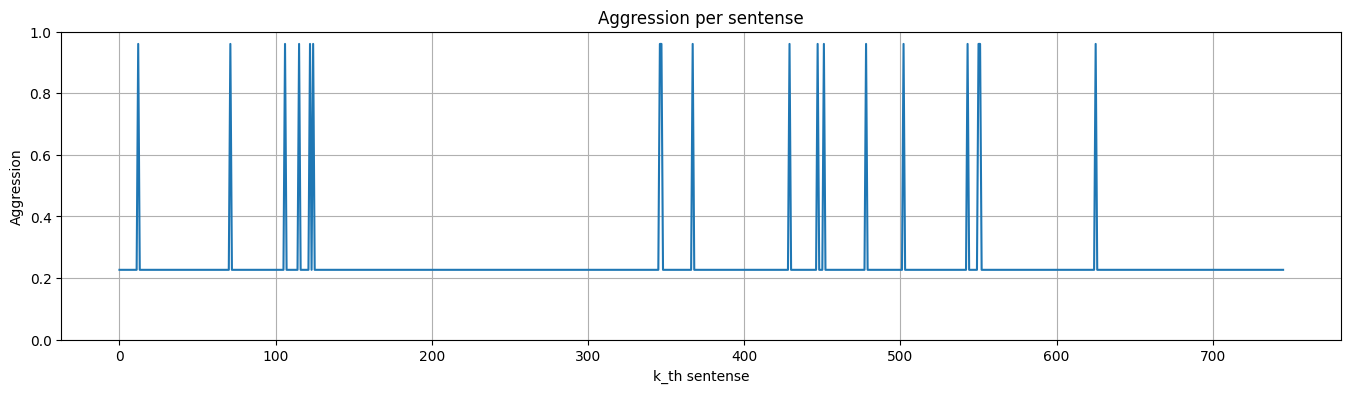

In [113]:
# 위에서 선언한 3개의 함수를 통합하는 함수

def test_all(path, parameter):
    test_sample = test(path)
    evaluate(test_sample, parameter)
    make_graph(test_sample)
    #test_sample.to_excel('Result_'+path, index=False) # 해당 부분에서 현재는 엑셀 파일로 출력하는데 이 부분을 웹 환경에 맞게 변형시켜 사용하면 될 것 같음, 새로운 함수를 선언하여 모듈화 하는 것도 좋아보임 

test_all("Test/마이네임_1화.xlsx", 3) # 테스트 하고자 하는 파일의 경로와 평가를 위한 파라미터 k를 입력